Document for Model training



Importing packages

In [1]:
import matplotlib.pyplot as plt
from synDataFunctionality.TreeLib import Tree, genTree
import numpy as np
from synDataFunctionality.genInputFromLabel import labelToInput


Setting Constants

In [2]:
startX = 5
startY = 360
startAngle = 0
starWidth = 15
stopWidth = 3
startLength = 20
bifurcProb = 0.3


Make some trees 

In [3]:
from synDataFunctionality.saveSynData import genSynDat
import torch.utils.data as td
from DataLoaders import SynData

Make and save some synthetic data

In [4]:
lst = [startX, startY, starWidth, startLength, startAngle, stopWidth]
num = 9

# make num samples
genSynDat("SynDat/SynInput", "SynDat/SynLabel", lst, (736, 736), num)


Test that we can make a dataSet and it outputs data as expected

In [5]:
SynDataSet = SynData("SynDat/synInput", "SynDat/synLabel")

#Test we can retrieve data from Dataset
test, lab = SynDataSet[0]
print(test.shape)
print(lab.shape)

torch.Size([1, 736, 736])
torch.Size([1, 736, 736])


Visualize synthetic generated data

In [6]:
import torchvision
"""
#test that dataloader works, and show images
test_loader = td.DataLoader(SynDataSet, batch_size=2)

testIter = iter(test_loader)
for i in range(len(testIter)):
    imgs, labs = testIter.next()
    grid = torchvision.utils.make_grid(imgs) #.numpy()[0] hack to show tensor in plt
    plt.imshow(grid.numpy()[0], cmap="gray", vmin=0, vmax=255)
    plt.show()
    lab_grid = torchvision.utils.make_grid(labs)
    plt.imshow(lab_grid.numpy()[0], cmap="gray", vmin=0, vmax=1)
    plt.show()"""

'\n#test that dataloader works, and show images\ntest_loader = td.DataLoader(SynDataSet, batch_size=2)\n\ntestIter = iter(test_loader)\nfor i in range(len(testIter)):\n    imgs, labs = testIter.next()\n    grid = torchvision.utils.make_grid(imgs) #.numpy()[0] hack to show tensor in plt\n    plt.imshow(grid.numpy()[0], cmap="gray", vmin=0, vmax=255)\n    plt.show()\n    lab_grid = torchvision.utils.make_grid(labs)\n    plt.imshow(lab_grid.numpy()[0], cmap="gray", vmin=0, vmax=1)\n    plt.show()'

Check that transformations can be applied to dataSet

In [7]:
#Test transformations work correctly on dataloader:
from torchvision.transforms import RandomVerticalFlip, RandomHorizontalFlip, ColorJitter, CenterCrop, Normalize
from torchvision.transforms.functional import rotate
import torchvision

t_both = [RandomHorizontalFlip(p=0.5),  RandomVerticalFlip(p=0.5)]
#Maybe normalize imgs automatically in dataSet

In [8]:
TransDataSet = SynData("SynDat/synInput", "SynDat/synLabel", transforms_both=t_both)#, transforms_train=t_dat)


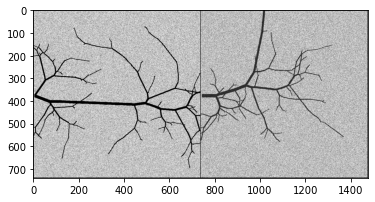

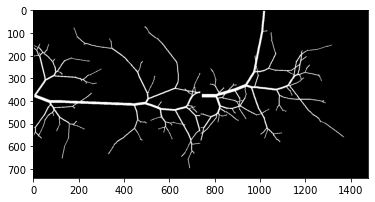

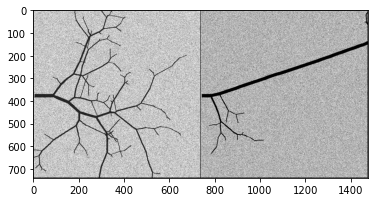

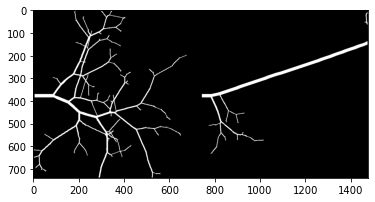

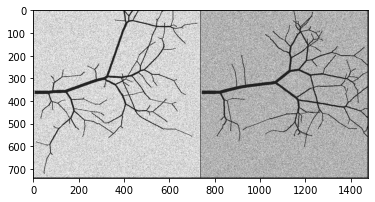

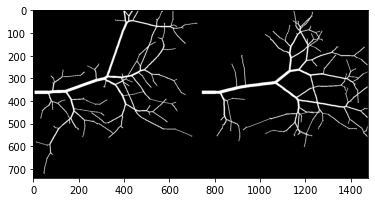

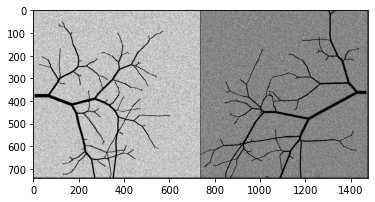

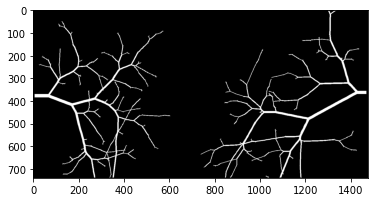

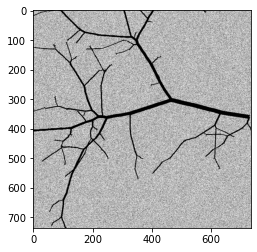

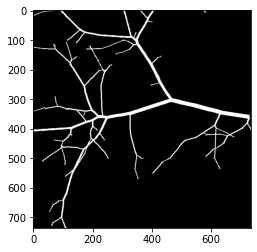

In [9]:
import torchvision
import numpy as np

#test that dataloader works, and show images
trans_loader = td.DataLoader(TransDataSet, batch_size=2)

transIter = iter(trans_loader)
for i in range(len(transIter)):
    imgs, labs = next(transIter)
    grid = torchvision.utils.make_grid(imgs).numpy()[0]
    #print(np.amax(np.array(imgs)))
    #print(np.amin(np.array(imgs)))
    plt.imshow(grid+1, cmap="gray", vmin=0, vmax=255)
    plt.show()
    lab_grid = torchvision.utils.make_grid(labs).numpy()[0]
    plt.imshow(lab_grid, cmap="gray", vmin=0, vmax=1)
    plt.show()

Experiment with Basic Unet (to test whether it works)

Import packages and files for Unet and training

In [10]:
from Unet.UNetBasic import UnetBasic
import torch
import torch.optim as optim
import torch.nn as nn
import torch.cuda


In [11]:
#make Unet

net1 = UnetBasic()

#Try to use cuda machine

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#check which device we are on

print(device)


cuda:0


Make training and testing images. Apply random transformations to them:

In [12]:
#note, we comment our genSynDat, as otherwise we kill previous generated data.

#Make 300 samples for training data:
#genSynDat("SynDat/SynInputTrain", "SynDat/SynLabelTrain", lst, (736, 736), 300)
trainingData = SynData("SynDat/SynInputTrain", "SynDat/SynLabelTrain", t_both)
#Make 50 samples as test data:
#genSynDat("SynDat/SynInputTest", "SynDat/SynLabelTest", lst, (736, 736), 50)
testData = SynData("SynDat/SynInputTest", "SynDat/SynLabelTest", t_both)

trainLoader = td.DataLoader(trainingData, shuffle=True)
testLoader = td.DataLoader(testData, shuffle=True)

Training our basic Unet

In [13]:
from trainingFunctionality import trainLoop

net1.to(device) #For now is cpu, but will hopefully be CUDA later
net1 = net1.float() #hack that should remove float error

#Adam for now
optimizer = optim.Adam(net1.parameters(), lr=0.001)
criterion = nn.BCELoss()
criterion.to(device)

#Training, pray for me
trainLoss, testLoss , net = trainLoop(net1, optimizer, criterion, device, 5, trainLoader, testLoader, print_interv=5)

[1,     5] loss: 0.087
[1,    10] loss: 0.076
[1,    15] loss: 0.071
[1,    20] loss: 0.066
[1,    25] loss: 0.061
[1,    30] loss: 0.056
[1,    35] loss: 0.052
[1,    40] loss: 0.048
[1,    45] loss: 0.046
[1,    50] loss: 0.043
[1,    55] loss: 0.042
[1,    60] loss: 0.039
[1,    65] loss: 0.037
[1,    70] loss: 0.035
[1,    75] loss: 0.033
[1,    80] loss: 0.031
[1,    85] loss: 0.030
[1,    90] loss: 0.029
[1,    95] loss: 0.027
[1,   100] loss: 0.026
[1,   105] loss: 0.025
[1,   110] loss: 0.023
[1,   115] loss: 0.022
[1,   120] loss: 0.021
[1,   125] loss: 0.020
[1,   130] loss: 0.020
[1,   135] loss: 0.018
[1,   140] loss: 0.017
[1,   145] loss: 0.016
[1,   150] loss: 0.016
[1,   155] loss: 0.015
[1,   160] loss: 0.015
[1,   165] loss: 0.014
[1,   170] loss: 0.013
[1,   175] loss: 0.013
[1,   180] loss: 0.012
[1,   185] loss: 0.012
[1,   190] loss: 0.011
[1,   195] loss: 0.012
[1,   200] loss: 0.010
[1,   205] loss: 0.010
[1,   210] loss: 0.009
[1,   215] loss: 0.009
[1,   220] 

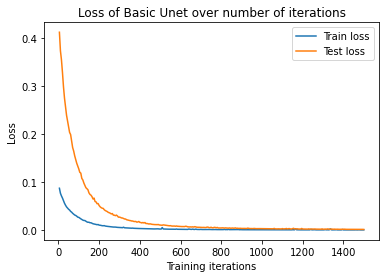

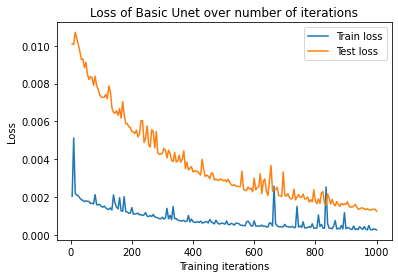

In [19]:
from trainingFunctionality import visualizeLoss
visualizeLoss("Basic Unet", 5, trainLoss, testLoss)
visualizeLoss("Basic Unet", 5, trainLoss[100:], testLoss[100:])

actual label:


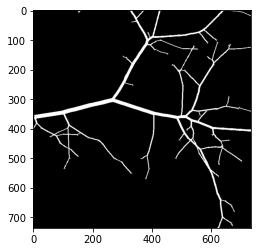

predicted lab:


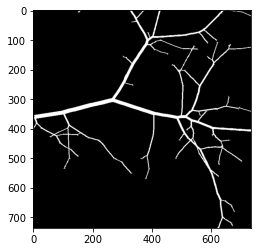

f1 score: 0.99976


In [76]:
from sklearn.metrics import f1_score
#Visualize a prediction of transIter

#Make val dataset
valData = SynData("SynDat/SynInput/", "SynDat/SynLabel/")
valLoader = td.DataLoader(valData, shuffle=True)
valIter = iter(valLoader)
val_input, val_lab_orig = next(valIter)
#connect val data to device
val_input, val_lab = val_input.to(device), val_lab_orig.to(device)
#make prediction
val_out = (net(val_input.float())).cpu().detach() #put output back on cpu
#val_out = val_out
#val_out = np.array(val_out.float())
#print(val_out.shape)
print("actual label:")
plt.imshow(torchvision.utils.make_grid(val_lab_orig).numpy()[0], cmap="gray", vmin=0, vmax=1)
plt.show()
print("predicted lab:")
plt.imshow(torchvision.utils.make_grid(val_out).numpy()[0] > 0.5, cmap="gray", vmin=0, vmax=1)
plt.show()
#print(val_lab_orig.numpy()[0])
orig_lab = val_lab_orig.numpy()[0]
pred_lab = np.array(val_out.numpy()[0] > 0.5).astype(int)

print("f1 score: {0:.5f}".format(f1_score(orig_lab[0], pred_lab[0], average="micro")))


Kill all files created in this session, such to diminish clutter

In [14]:
#kill generated files such that we diminish clutter
from synDataFunctionality.saveSynData import order_66

#order_66("SynDat/synInputTrain", "SynDat/synLabelTrain")
